In [26]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb

In [27]:
# Read the CSV VISUALIZATION data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_visualization):
    df = s3_utils.read_csv_from_s3(output_file_key_data_visualization)

FEATURE ENGINEERING

1. Encoding categorical variables into numerical representations

In [28]:
#Initializing the tag encoder
label_encoder = LabelEncoder()

#Applying the encoding to the "pack" column:
df['pack_encoded'] = label_encoder.fit_transform(df['pack'])


In [29]:
df['pack'].value_counts()

pack
102    116986
K01     77083
O01     50478
105     44936
107     27952
103     24860
104      6776
301      4208
101      1816
109        86
M01         7
108         2
Name: count, dtype: int64

In [30]:
df['pack_encoded'].value_counts()

pack_encoded
1     116986
9      77083
11     50478
4      44936
5      27952
2      24860
3       6776
8       4208
0       1816
7         86
10         7
6          2
Name: count, dtype: int64

In [31]:
#Dropping pack and status features
df.drop(columns=['pack'], inplace=True)
df.drop(columns=['status'], inplace=True)

2. Remove or transform irrelevant or redundant features to streamline the feature space

In [32]:
df['number_products'] = df['cr_prod_cnt_il'].fillna(0) + df['cr_prod_cnt_vcu'].fillna(0) + df['cr_prod_cnt_tovr'].fillna(0) + df['cr_prod_cnt_pil'].fillna(0) + df['cr_prod_cnt_cc'].fillna(0) + df['cr_prod_cnt_ccfp'].fillna(0)

In [33]:
df['number_products'].value_counts()

number_products
0     229194
1      80543
2      26356
3      10805
4       4552
5       2047
6        905
7        386
8        191
9         99
10        54
11        29
12        12
13         7
14         5
16         3
15         2
Name: count, dtype: int64

TARGET (Dependent Variable)

In [34]:
# Frequency of classes of dependent variable
df["target"].value_counts()

target
0    326265
1     28925
Name: count, dtype: int64

In [35]:
# Customers leaving the bank
churn = df.loc[df["target"]==1]

In [36]:
# Customers who did not leave the bank
not_churn = df.loc[df["target"]==0]

In [37]:
# Frequency of not_churn group according to Months of being customers
not_churn["clnt_setup_tenor"].value_counts().sort_values()

clnt_setup_tenor
8.824087       1
10.598399      1
2.824206       1
7.807958       1
7.843023       1
            ... 
1.583333     213
1.416667     216
0.750000     262
0.666667     263
0.583333     287
Name: count, Length: 12577, dtype: int64

In [38]:
# Frequency of churn group according to Months of being customers
churn["clnt_setup_tenor"].value_counts().sort_values()

clnt_setup_tenor
8.961184     1
8.813334     1
9.966560     1
1.985377     1
8.826775     1
            ..
0.361721    32
0.666667    33
0.750000    34
0.916667    40
0.583333    42
Name: count, Length: 8173, dtype: int64

AGE

In [39]:

# examining the age of the not_churn group
not_churn["age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    326265.000000
mean         38.235094
std          11.336087
min          14.000000
5%           23.000000
25%          29.000000
50%          36.000000
75%          46.000000
90%          55.000000
95%          59.000000
99%          68.000000
max          94.000000
Name: age, dtype: float64

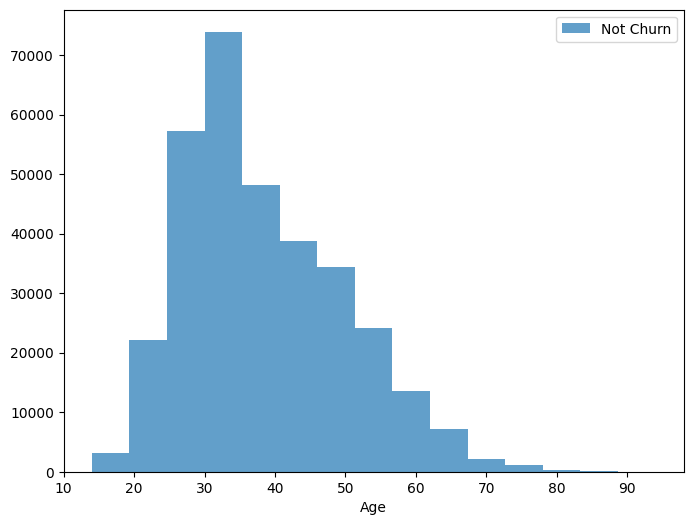

In [40]:
import matplotlib.pyplot as pyplot

# distribution of the Age for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(not_churn["age"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [41]:
# examining the age of the churn group
churn["age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    28925.000000
mean        36.523042
std         11.626229
min         14.000000
5%          21.000000
25%         28.000000
50%         34.000000
75%         44.000000
90%         54.000000
95%         58.000000
99%         68.000000
max         88.000000
Name: age, dtype: float64

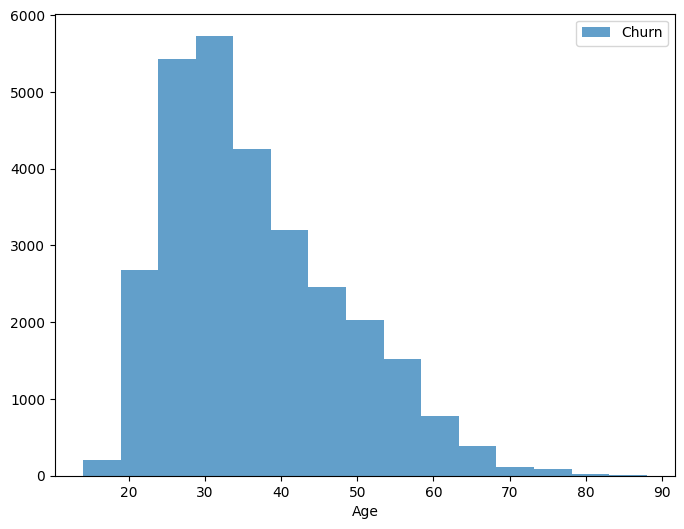

In [42]:
# distribution of the Age for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(churn["age"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

d:\Users\presc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Users\presc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


d:\Users\presc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


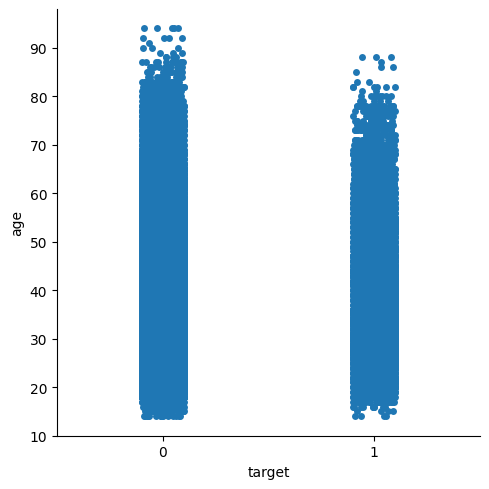

In [43]:
sns.catplot(x='target', y='age', data=df)
plt.show()

In [44]:
#Discretizing age feature 

# Defining category limits
bins = [float('-inf'), 19, 56, float('inf')]  # Categories: (-inf, 19], (19, 56], (56, inf)

# Defining labels
labels = ['Under 20', '20-55 years', 'Over 55']

# Creating a new feature with the categories created 
df['new_age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Assigning numerical values to categories
category_mapping = {'Under 20': 0, '20-55 years': 1, 'Over 55': 2}
df['new_age_category_numeric'] = df['new_age_category'].map(category_mapping)

print(df.head())

       id  cr_prod_cnt_il  amount_rub_clo_prc  turnover_dynamic_il_1m  \
0  146841               0            0.000000                     0.0   
1  146842               0            0.041033                     0.0   
2  146843               0            0.006915                     0.0   
3  146844               0            0.000000                     0.0   
4  146845               0            0.000000                     0.0   

   amount_rub_sup_prc  rest_dynamic_fdep_1m  rest_dynamic_save_3m  \
0            0.000000                   0.0              0.541683   
1            0.244678                   0.0              0.000000   
2            0.000000                   0.0              0.000000   
3            0.000000                   0.0              0.005874   
4            0.000000                   0.0              0.000000   

   cr_prod_cnt_vcu   rest_avg_cur  amount_rub_nas_prc  trans_count_sup_prc  \
0                0  156067.339800                 0.0             0.

In [45]:
print(df['new_age_category'].unique())
print(df['new_age_category'].value_counts())

['20-55 years', 'Over 55', 'Under 20']
Categories (3, object): ['Under 20' < '20-55 years' < 'Over 55']
new_age_category
20-55 years    322964
Over 55         30753
Under 20         1473
Name: count, dtype: int64


Number of products

In [46]:
# Frequency of not_churn group according to NumOfProducts
not_churn["number_products"].value_counts().sort_values()

number_products
15         1
16         2
14         4
13         7
12        11
11        27
10        46
9         93
8        179
7        351
6        835
5       1875
4       4173
3       9991
2      24471
1      74168
0     210031
Name: count, dtype: int64

In [47]:

# Frequency of not_churn group according to NumOfProducts
not_churn["number_products"].value_counts().sort_values()

number_products
15         1
16         2
14         4
13         7
12        11
11        27
10        46
9         93
8        179
7        351
6        835
5       1875
4       4173
3       9991
2      24471
1      74168
0     210031
Name: count, dtype: int64

In [48]:
# Frequency of churn group according to NumOfProducts
churn["number_products"].value_counts().sort_values()

number_products
12        1
14        1
15        1
16        1
11        2
9         6
10        8
8        12
7        35
6        70
5       172
4       379
3       814
2      1885
1      6375
0     19163
Name: count, dtype: int64

3. Standarization and normalization

In [49]:
df['clnt_setup_tenor_years'] = df['clnt_setup_tenor'] * 12

In [50]:
# normalizing tenure in relation to age, potentially offering a fresh perspective on customer retention based on age.
df["new_setup_tenor"] = df["clnt_setup_tenor_years"]/df["age"]
df.head()

,id,cr_prod_cnt_il,amount_rub_clo_prc,turnover_dynamic_il_1m,amount_rub_sup_prc,rest_dynamic_fdep_1m,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,amount_rub_nas_prc,trans_count_sup_prc,trans_count_nas_prc,cr_prod_cnt_tovr,cr_prod_cnt_pil,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cr_prod_cnt_cc,rest_dynamic_fdep_3m,rest_dynamic_il_1m,cr_prod_cnt_ccfp,rest_dynamic_cur_1m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,rest_dynamic_il_3m,turnover_dynamic_il_3m,rest_dynamic_paym_1m,turnover_dynamic_cur_3m,clnt_setup_tenor,turnover_dynamic_paym_3m,turnover_dynamic_paym_1m,rest_dynamic_cc_1m,turnover_dynamic_cc_1m,rest_dynamic_cc_3m,turnover_dynamic_cc_3m,target,age_group,pack_encoded,number_products,new_age_category,new_age_category_numeric,clnt_setup_tenor_years,new_setup_tenor
0,146841,0,0.000000,0.0,0.000000,0.0,0.541683,0,156067.339800,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,55.0,0,0.0,0.0,0,0.134651,0.0,0.0,0.474134,0.131910,0.0,0.0,0.0,0.0,0.442285,1.593023,0.0,0.0,0.0,0.0,0.0,0.0,0,40-60,9,0,20-55 years,1,19.116275,0.347569
1,146842,0,0.041033,0.0,0.244678,0.0,0.000000,0,4278.845817,0.0,0.454545,0.0,0,0,0.0,0.109091,0.410691,0.0,46.0,0,0.0,0.0,0,0.239365,0.0,0.0,0.384264,0.101934,0.0,0.0,0.0,0.0,0.515876,1.587647,0.0,0.0,0.0,0.0,0.0,0.0,0,40-60,1,0,20-55 years,1,19.051759,0.414169
2,146843,0,0.006915,0.0,0.000000,0.0,0.000000,0,112837.062800,0.0,0.000000,0.0,0,0,0.0,0.810811,0.925140,0.0,35.0,0,0.0,0.0,0,0.084341,0.0,0.0,0.336136,0.121041,0.0,0.0,0.0,0.0,0.522833,1.587647,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,1,0,20-55 years,1,19.051759,0.544336
3,146844,0,0.000000,0.0,0.000000,0.0,0.005874,0,42902.902880,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,31.0,0,0.0,0.0,0,0.005659,0.0,0.0,0.019648,0.000005,0.0,0.0,0.0,0.0,0.000189,1.583333,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,9,0,20-55 years,1,19.000000,0.612903
4,146845,0,0.000000,0.0,0.000000,0.0,0.000000,0,71906.476530,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,24.0,0,0.0,0.0,0,0.166946,0.0,0.0,0.556935,0.177869,0.0,0.0,0.0,0.0,0.593648,1.583333,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,1,0,20-55 years,1,19.000000,0.791667


In [51]:
#Dropping more redundant features 

#age and new setup tenor in years
df.drop(['age', 'clnt_setup_tenor_years', 'clnt_setup_tenor'], axis=1, inplace=True)

In [52]:
age_columns = [col for col in df.columns if 'age' in col]
print(age_columns)

['age_group', 'new_age_category', 'new_age_category_numeric']


In [53]:
#Dropping age_group 
df.drop(['age_group'], axis=1, inplace=True)

In [54]:
#Looking for columns with the word cnt 
cnt_columns = [col for col in df.columns if 'cnt' in col]
print(cnt_columns)

['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil', 'cr_prod_cnt_cc', 'cr_prod_cnt_ccfp']


In [55]:
#Dropping columns of individual products
df.drop(['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil', 'cr_prod_cnt_cc', 'cr_prod_cnt_ccfp'], axis=1, inplace=True)

In [56]:
# Looking for columns with the word turnover to sum later  
turnover_columns = [col for col in df.columns if 'turnover' in col]

# Printing results
print(turnover_columns)

['turnover_dynamic_il_1m', 'turnover_cc', 'turnover_paym', 'turnover_dynamic_cur_1m', 'turnover_dynamic_il_3m', 'turnover_dynamic_cur_3m', 'turnover_dynamic_paym_3m', 'turnover_dynamic_paym_1m', 'turnover_dynamic_cc_1m', 'turnover_dynamic_cc_3m']


In [57]:
# Sum the values of all turnover columns
df['total_turnover'] = df[['turnover_cc', 'turnover_paym']].sum(axis=1)

print(df[['total_turnover']].count())


total_turnover    355190
dtype: int64


In [58]:
# Discretizing the new total_turnover feature using pd.qcut() with 'duplicates' set to 'drop'
df['total_turnover_category'] = pd.qcut(df['total_turnover'], 6, labels=False, duplicates='drop')


In [59]:
# Drop the 'total_turnover' column from the DataFrame
df.drop(columns=['total_turnover', 'turnover_cc', 'turnover_paym'], inplace=True)


In [60]:
#Looking for columns related to 1m  
one_month_columns = [col for col in df.columns if '1m' in col]
print(one_month_columns)

['turnover_dynamic_il_1m', 'rest_dynamic_fdep_1m', 'rest_dynamic_il_1m', 'rest_dynamic_cur_1m', 'turnover_dynamic_cur_1m', 'rest_dynamic_paym_1m', 'turnover_dynamic_paym_1m', 'rest_dynamic_cc_1m', 'turnover_dynamic_cc_1m']


In [61]:
# Sum the values of all turnover columns related to dynamic in one month 
df['total_turnover_1m'] = df[['turnover_dynamic_il_1m', 'turnover_dynamic_cur_1m', 'turnover_dynamic_paym_1m','turnover_dynamic_cc_1m' ]].sum(axis=1)

print(df[['total_turnover_1m']].count())

total_turnover_1m    355190
dtype: int64


In [62]:
# Discretizing the new total_turnover_1m feature using pd.qcut() with 'duplicates' set to 'drop'
df['total_turnover_1m_category'] = pd.qcut(df['total_turnover_1m'], 6, labels=False, duplicates='drop')

In [63]:
# Drop the 'total_turnover' column from the DataFrame related to 1m
df.drop(columns=['turnover_dynamic_il_1m', 'turnover_dynamic_cur_1m', 'turnover_dynamic_paym_1m','turnover_dynamic_cc_1m', 'total_turnover_1m' ], inplace=True)

In [64]:
#Looking for columns related to 3 months
three_months_columns = [col for col in df.columns if '3m' in col]
print(three_months_columns)

['rest_dynamic_save_3m', 'rest_dynamic_fdep_3m', 'rest_dynamic_cur_3m', 'rest_dynamic_paym_3m', 'rest_dynamic_il_3m', 'turnover_dynamic_il_3m', 'turnover_dynamic_cur_3m', 'turnover_dynamic_paym_3m', 'rest_dynamic_cc_3m', 'turnover_dynamic_cc_3m']


In [65]:
# Sum the values of all turnover columns related to dynamic in three months 
df['total_turnover_3m'] = df[['turnover_dynamic_il_3m', 'turnover_dynamic_cur_3m', 'turnover_dynamic_paym_3m','turnover_dynamic_cc_3m' ]].sum(axis=1)

print(df[['total_turnover_3m']].count())

total_turnover_3m    355190
dtype: int64


In [66]:
# Discretizing the new total_turnover_3m feature using pd.qcut() with 'duplicates' set to 'drop'
df['total_turnover_3m_category'] = pd.qcut(df['total_turnover_3m'], 6, labels=False, duplicates='drop')

In [67]:
# Drop the 'total_turnover' column from the DataFrame related to three months
df.drop(columns=['turnover_dynamic_il_3m', 'turnover_dynamic_cur_3m', 'turnover_dynamic_paym_3m','turnover_dynamic_cc_3m', 'total_turnover_3m', 'total_turnover_3m' ], inplace=True)

In [68]:
numeric_columns =[]
cat_columns=[]
for col in df.columns:
    if df[col].dtype == 'object':
        cat_columns.append(col)
    else:
        numeric_columns.append(col)

VISUALIZING HEATMAP TO FIND MORE RELATED FEATURES TO DROP 

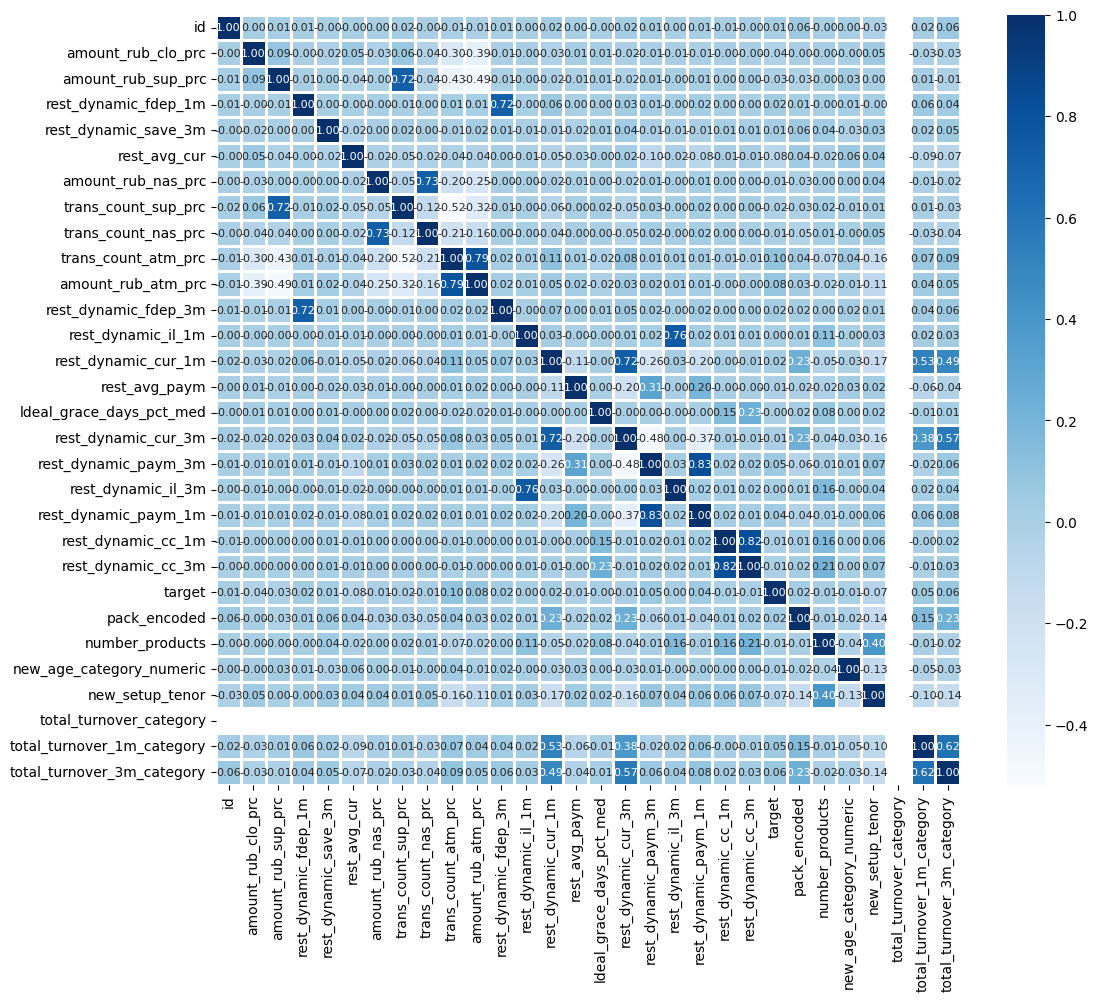

In [69]:
# Excluding new_age_category column
numeric_columns_without_new_age = [col for col in df[numeric_columns].columns if col != 'new_age_category']

# Calculating correlation
correlation_matrix = df[numeric_columns_without_new_age].corr()

# Setting the figure size
plt.figure(figsize=(12, 10))

# Visualizing heatmap 
sns.heatmap(correlation_matrix, cmap='Blues', linewidths=1, annot=True, annot_kws={"size": 8}, fmt=".2f")
plt.show()




It is decided based on the heatmap to eliminate the columns: 'trans_count_nas_prc', 'trans_count_sup_prc', 'trans_count_atm_prc'.

Likewise, it was determined to eliminate the columns related to 'rest_dynamic' that describe information for 1 month, these are:
'rest_dynamic_fdep_1m', 'rest_dynamic_il_1m', 'rest_dynamic_cur_1m', 'rest_dynamic_paym_1m', 'rest_dynamic_cc_1m'

In [70]:
#Dropping redundant feature finding in the heatmap 
df.drop(columns=['trans_count_nas_prc', 'new_age_category','trans_count_sup_prc', 'trans_count_atm_prc','rest_dynamic_fdep_1m', 'rest_dynamic_il_1m', 'rest_dynamic_cur_1m', 'rest_dynamic_paym_1m', 'rest_dynamic_cc_1m'], inplace=True)


4. Standarizing 

In [71]:
# Scaling features using statistics that are robust to outliers.

def robust_scaler(variable):
    if variable.dtype == 'object':  # If the variable is of type 'object', it's likely a label encoded column
        return variable
    else:  # If the variable is numeric, apply robust scaling
        var_median = variable.median()
        quartile1 = variable.quantile(0.25)
        quartile3 = variable.quantile(0.75)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.05)
            quartile3 = variable.quantile(0.95)
            interquantile_range = quartile3 - quartile1
            if int(interquantile_range) == 0:
                quartile1 = variable.quantile(0.01)
                quartile3 = variable.quantile(0.99)
                interquantile_range = quartile3 - quartile1
                z = (variable - var_median) / interquantile_range
                return round(z, 3)

            z = (variable - var_median) / interquantile_range
            return round(z, 3)
        else:
            z = (variable - var_median) / interquantile_range
        return round(z, 3)


### End of Featured Engineering
#### send df to S3 for modelling

In [76]:
# This Write the analyzed data to S3
s3_utils.write_csv_to_s3(output_file_key_data_model_three_train, df)
print(f"File '{output_file_key_data_model_three_train}' successfully written to bucket '{s3_utils.bucket_name}'.")

File 'dev/final/model_c/bank_data_train.csv' successfully written to bucket 'introtoaiwinter24'.
